# Mesa tutorial

In [1]:
from mesa import Agent, Model

## Setting up the model

In [2]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

In [3]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

## Adding the scheduler

In [4]:
from mesa import Agent, Model
from mesa.time import RandomActivation

In [8]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # print(self.unique_id)
        pass

In [6]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [9]:
empty_model = MoneyModel(10)
empty_model.step()

0
3
9
2
1
8
6
4
7
5


## Agent Step

In [10]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

In [11]:
model = MoneyModel(10)
for i in range(10):
    model.step()

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

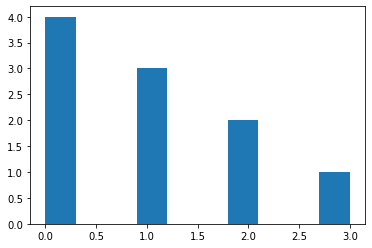

In [14]:
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)
plt.show()

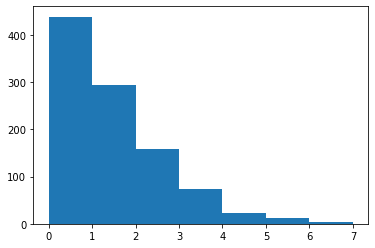

In [15]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))
plt.show()

## Adding space

In [16]:
from mesa.space import MultiGrid

In [19]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [20]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [21]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

In [22]:
import numpy as np

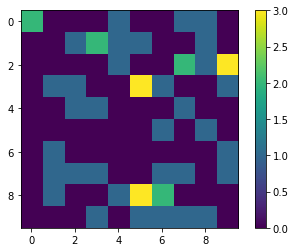

In [23]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()
plt.show()

## Collecting Data

In [24]:
from mesa.datacollection import DataCollector

In [25]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [26]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [27]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},  # `compute_gini` defined above
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [28]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

### Model-level collection

<AxesSubplot:>

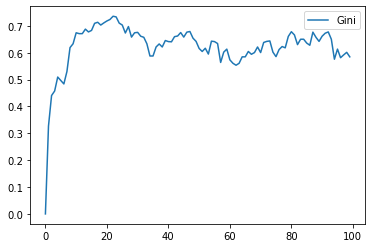

In [29]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

### Agent-level collection

In [30]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

### Agents wealth at the model’s end

<AxesSubplot:>

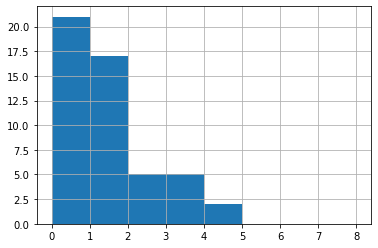

In [31]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

### Wealth of a given agent

<AxesSubplot:xlabel='Step'>

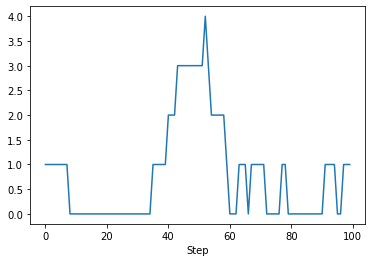

In [32]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

## Batch Run

In [34]:
from mesa.batchrunner import BatchRunner

In [35]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [36]:
fixed_params = {
    "width": 10,
    "height": 10
}

variable_params = {"N": range(10, 500, 10)}

# The variables parameters will be invoke along with the fixed parameters allowing for either or both to be honored.
batch_run = BatchRunner(
    MoneyModel,
    variable_params,
    fixed_params,
    iterations=5,
    max_steps=100,
    model_reporters={"Gini": compute_gini}
)

batch_run.run_all()

245it [02:21,  1.73it/s]


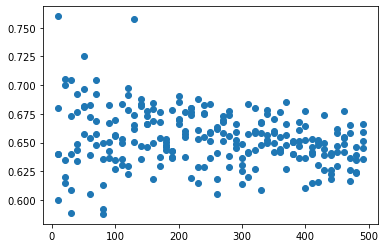

In [37]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)
plt.show()

## Grid Visualization

In [38]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

In [39]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Color": "red",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    return portrayal

In [45]:
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

In [41]:
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}


### Changing the agents

In [44]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

In [47]:
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8522 # The default
server.launch()

Interface starting at http://127.0.0.1:8522


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step

### Adding a chart

In [48]:
from mesa.visualization.modules import ChartModule

In [49]:
chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

In [50]:
server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})

In [51]:
server.port = 8523 # The default
server.launch()

Interface starting at http://127.0.0.1:8523


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step